# Test for the climate module

The climate module uses the following impulse response model as a box-model solution:
$$
T_{k}(t) = \int_{0}^{t} \frac{F(t^{'})}{\lambda} \sum_{j} \frac{A_{kj}}{\tau_{j}} \exp\left( - \frac{t - t'}{\tau_{j}} \right) dt^{'}, \quad (k=\mathrm{S}, 1, 2;\; j=0, 1, 2),
$$
where $T_{k}$ is the layer-$k$ temperature anomaly; $F$ is effective radiative forcing; $\tau_{j}$ is the $j$-th element of time constants; and $\tau_{j}$ is the fraction of the $j$-th contribution to the layer-$k$ anomaly ($\sum_{j} A_{kj} = 1$). The number of layers in the box model is arbitrary, but two or three (default) are typical. Layer S represents the surface, and for the default setting layers 1 and 2 are equivalent to the intermediate and deep ocean.The sum of the exponentials divided by $\lambda$ corresponds to the impulse response function of this forcing-response system.

The above equation ensures the linearized global energy balance:
$$
N(t) = F(t) - \lambda T_{\mathrm{S}}(t),
$$
where $N$ is the top-of-atmosphere energy imbalance (downward positive), assumed to be equivalent to ocean heat uptake.

In [2]:
import numpy as np
from mce.core.forcing import RfCO2
from mce.core.climate import IrmBase
from mce.util.plot_base import PlotBase

In [3]:
forcing = RfCO2()
irm = IrmBase()
myplt = PlotBase()

In [4]:
# Time constants in years
tauj = irm.parms.tauj
tauj

array([  1.033,  10.48 , 260.6  ])

In [5]:
# Non-dimensional amplitudes of the surface temperature response
asj = irm.parms.asj
asj, asj.sum()

(array([0.2616, 0.3362, 0.4022]), 1.0)

In [6]:
# Climate feedback parameter in W/m2/K
lamb = irm.parms.lamb
lamb

1.053

In [7]:
# Derivation of climate sensitivity metrics
# ECS: equilibrium climate sensitivity
# TCR: transient climate response
q2x = forcing.x2erf(2)
f1p = forcing.x2erf(1.01)
ecs = q2x / lamb
t70 = np.log(2)/np.log(1.01)
rwf = 1 - (asj * tauj * (1 - np.exp(-t70/tauj))).sum() / t70
tcr = ecs * rwf
'ECS: {:.3f} K, TCR: {:.3f} K'.format(ecs, tcr)

'ECS: 3.039 K, TCR: 1.801 K'

In [8]:
# Get full-layer parameters
lambk, xik, akj = irm.get_parms_ebm()

In [9]:
# climate feedback parameter and heat exchange coefficients
lambk, lambk[0] == lamb

(array([1.053     , 2.12318201, 0.85537252]), True)

In [10]:
# Non-dimensional amplitudes
akj, akj.sum(axis=1), np.alltrue(np.equal(akj[0], asj))

(array([[ 2.61600000e-01,  3.36200000e-01,  4.02200000e-01],
        [-4.64816730e-02,  4.47477355e-01,  5.99004318e-01],
        [ 4.35168298e-04, -4.64815102e-02,  1.04604634e+00]]),
 array([1., 1., 1.]),
 True)

In [11]:
# Heat capacities in J/m2/K devided by annual total seconds
xik

array([ 3.67069705, 15.42876743, 95.26363154])

In [12]:
# Consistency of the total heat capacity
lamb * (asj * tauj).sum() == xik.sum()

True

In [13]:
# Equivalent ocean depths in m
lambk, depk, akj = irm.get_parms_ebm(ret_depth=True)
depk

array([ 37.89404978, 159.27723616, 983.443947  ])

In [14]:
# Idealized step response
time = np.arange(151).astype('d')
step_tres = irm.response_ideal(time)
step_tres_full = irm.response_ideal(time, akj=akj)
step_flux = irm.response_ideal(time, variable='flux')
step_heat = irm.response_ideal(time, variable='heat')

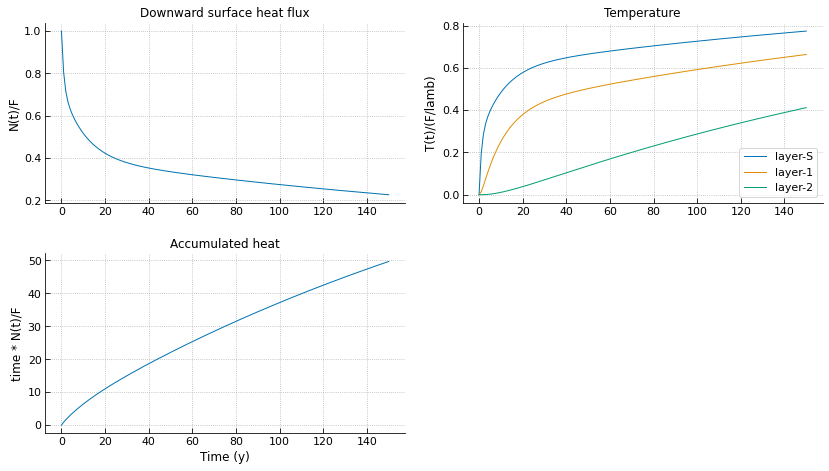

In [15]:
kw_space = {'aspect': 2., 'height': 2.5}
myplt.init_regular(3, col=2, kw_space=kw_space)

ax = myplt(0)
ax.plot(time, step_flux)
ax.set_ylabel('N(t)/F')
ax.set_title('Downward surface heat flux')
ax.grid()

ax = myplt(1)
ax.plot(time, step_tres_full)
ax.legend(ax.lines, ['layer-S', 'layer-1', 'layer-2'])
ax.set_ylabel('T(t)/(F/lamb)')
ax.set_title('Temperature')
ax.grid()

ax = myplt(2)
ax.plot(time, step_heat)
ax.set_xlabel('Time (y)')
ax.set_ylabel('time * N(t)/F')
ax.set_title('Accumulated heat')
ax.grid()

In [16]:
# Consistency of the surface and full computing
np.array_equal(step_tres, step_tres_full[:, 0])

True

In [17]:
# Consistency of the temperature and heat flux
np.array_equal(step_tres, 1 - step_flux)

True

In [18]:
# Consistency of the accumulated heat
np.allclose((step_tres_full / lamb * xik).sum(1), step_heat)

True

In [19]:
# Idealized ramp response
time = np.linspace(0., t70)
ramp_tres = irm.response_ideal(time, kind='ramp')
ramp_tres_full = irm.response_ideal(time, kind='ramp', akj=akj)
ramp_flux = irm.response_ideal(time, kind='ramp', variable='flux')
ramp_heat = irm.response_ideal(time, kind='ramp', variable='heat')

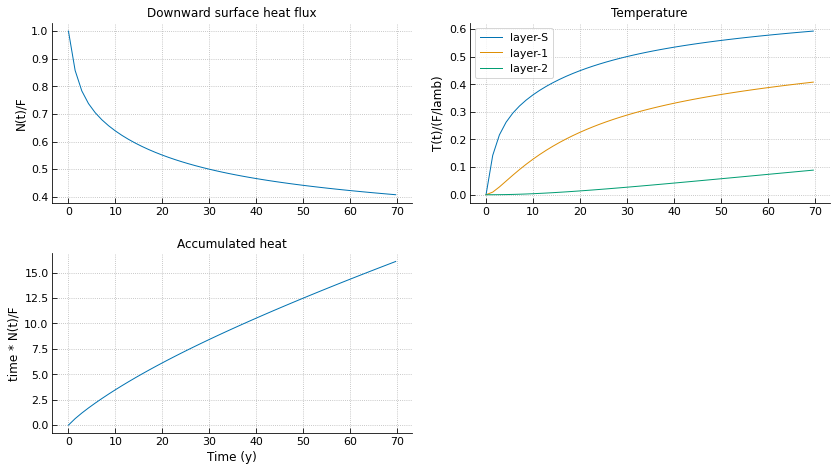

In [20]:
myplt.init_regular(3, col=2, kw_space=kw_space)

ax = myplt(0)
ax.plot(time, ramp_flux)
ax.set_ylabel('N(t)/F')
ax.set_title('Downward surface heat flux')
ax.grid()

ax = myplt(1)
ax.plot(time, ramp_tres_full)
ax.legend(ax.lines, ['layer-S', 'layer-1', 'layer-2'])
ax.set_ylabel('T(t)/(F/lamb)')
ax.set_title('Temperature')
ax.grid()

ax = myplt(2)
ax.plot(time, ramp_heat)
ax.set_xlabel('Time (y)')
ax.set_ylabel('time * N(t)/F')
ax.set_title('Accumulated heat')
ax.grid()

In [21]:
# Consistency of the surface and full computing
np.array_equal(ramp_tres, ramp_tres_full[:, 0])

True

In [22]:
# Consistency of the temperature and heat flux
np.array_equal(ramp_tres, 1 - ramp_flux)

True

In [23]:
# Consistency of the accumulated heat
np.allclose((ramp_tres_full / lamb * xik).sum(1), ramp_heat)

True

In [24]:
# Consistency of TCR
np.allclose(tcr, ramp_tres[-1] * f1p * t70 / lamb)

True

In [25]:
# General time integration
rf = forcing.xl2erf(time*np.log(1.01))
tres2 = irm.response(time, rf)
tres2_full = irm.response(time, rf, akj=akj)

In [26]:
# Comparison between the numerical and analytical solutions
np.allclose(tres2, ramp_tres * f1p * time / lamb)

True

In [27]:
# Comparison in the full layers
np.allclose(
    tres2_full,
    ramp_tres_full * f1p * time.reshape((-1, 1)) / lamb)

True

In [28]:
# Test for restart
ta = np.zeros(tres2_full.shape)
tkjlast = np.zeros((3, 3))

for k in range(len(time)-1):
    irm.tkjlast = tkjlast
    tapr = irm.response(time[:2], rf[k:k+2], init=False, akj=akj)[1]
    irm.tkjlast = tkjlast
    ta[k+1] = irm.response(time[:2], rf[k:k+2], init=False, akj=akj)[1]
    tkjlast = irm.tkjlast.copy()

np.allclose(tres2_full, ta)

True